In [1]:
import os
import re
from os.path import join

import sympy
from sympy import Symbol, sqrt, cos, pi, symbols
import numpy as np
import matplotlib.pylab as plt
import pandas as pd
from collections import OrderedDict

import qnet
from qnet.algebra import *

import QDYN

from src.notebook_plots_v1 import plot_bs_decay, display_hamiltonian, display_eq, show_summary_dicke
from src.single_sided_network_v1 import network_slh
from src.dicke_single_model_v1 import write_dicke_single_model, err_dicke_single
from src.doit_actions_v1 import run_traj_prop

from doit.tools import register_doit_as_IPython_magic

In [2]:
qnet.init_printing()

$
\newcommand{ket}[1]{\vert #1 \rangle}
\newcommand{bra}[1]{\langle #1 \vert}
\newcommand{Op}[1]{\hat{#1}}
$

# Analysis: Do we gain anything from using 32 trajectories?

*This notebook used a buggy version of QDYN where the MCWF trajectory optimization would use a simple non-Hermtian propagation for the forward propagation*

As a result, the analysis in this notebook is not very informative.

## collect runfolders

In [4]:
DATA_ROOT_32 = './data/dicke1_QSL_xxx'
DATA_ROOT_01 = './data/dicke1_QSL_1traj_xxx/'

In [5]:
RX_LEAFFOLDER = re.compile(r'rf_(?P<nodes>\d+)nodes_T(?P<T>[\d_]+)')

In [13]:
def collect_runfolder_pairs(data_root_32, data_root_01):
    runfolders = []
    for dirpath, dirnames, filenames in os.walk(data_root_32):
        if not dirnames:
            leafname = os.path.split(dirpath)[-1]
            if RX_LEAFFOLDER.match(leafname):
                dirpath_01 = dirpath.replace(data_root_32, data_root_01)
                if os.path.isdir(dirpath_01):
                    runfolders.append((dirpath, dirpath_01))
                else:
                    print("%s does not have corresponding runfolder %s" % (dirpath, dirpath_01))
            else:
                print(
                    "%s does not match %s" % (dirpath, rx_leaffolder.pattern))
    return runfolders

## compare convergence

In [27]:
import matplotlib.gridspec as gridspec

In [50]:
def plot_convergence_comparison(runfolder_pairs):
    n = len(runfolder_pairs)
    fig = plt.figure(figsize=(10, 6*n))
    gs = gridspec.GridSpec(n, 1)
    for i, (rf32, rf01) in enumerate(runfolder_pairs):
        conv = QDYN.octutils.OCTConvergences()
        conv.load_file(
            rf32.split('/')[-1] + ' (32)',
            join(rf32, 'oct_iters.dat'))
        conv.load_file(
            rf01.split('/')[-1] + ' (1)',
            join(rf01, 'oct_iters.dat'))
        ax = fig.add_subplot(gs[i])
        for (key, data) in conv.data.items():
            ax.plot(data.iter, data.J_T, label=key)
        ax.legend()
        ax.set_yscale('log')
        ax.set_xlabel("iteration")
        ax.set_ylabel("error")
    plt.show(fig)

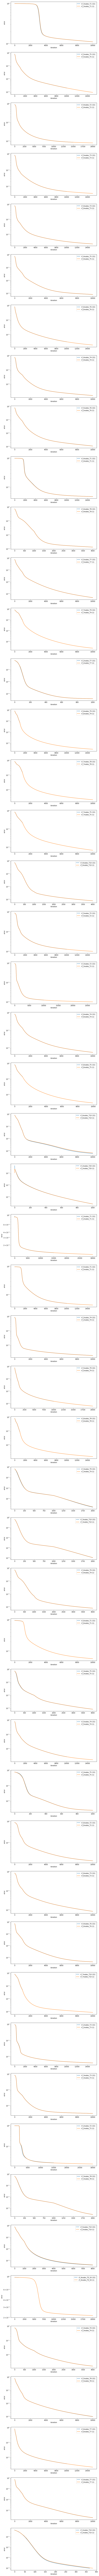

In [51]:
plot_convergence_comparison(
    collect_runfolder_pairs(DATA_ROOT_32, DATA_ROOT_01))